# AEX Preprocessing

## Libraries and Drive

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import os
os.chdir('/content/drive/My Drive/Volatility_forecasting/')

In [ ]:
!pip install neuralforecast ruptures arch dask[dataframe] scikit-learn statsforecast
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

## Data preparation

In [ ]:
import pandas as pd
import os
import numpy as np

# Define the path and reference file
data_path = 'Data/AEX/'
output_path = 'Data/AEX/'
reference_file = 'AEX_840E.xlsx'

# Step 1: Load and process the reference file (840E)
reference_df = pd.read_excel(os.path.join(data_path, reference_file), sheet_name='Sheet1')
reference_df = reference_df.melt(id_vars=['Name'], var_name='Date', value_name='840E')

# Clean the unique_id (remove anything after " - " if present)
reference_df['Name'] = reference_df['Name'].str.split(' - ').str[0]
reference_df.columns = ['unique_id', 'ds', '840E']
reference_df['ds'] = pd.to_datetime(reference_df['ds']).dt.date

# Filter data within the range 2016-01-01 to 2023-12-31
reference_df = reference_df[(reference_df['ds'] >= pd.to_datetime('2016-01-01').date()) &
                            (reference_df['ds'] <= pd.to_datetime('2023-12-31').date())]

# Identify unique_ids with no missing values in 840E after date filtering
complete_unique_ids = reference_df.groupby('unique_id').filter(lambda x: x['840E'].notna().all())['unique_id'].unique()

# Filter the reference_df to only include complete unique_ids
reference_df = reference_df[reference_df['unique_id'].isin(complete_unique_ids)]
reference_df = reference_df.sort_values(by=['unique_id', 'ds'])

# Define the date ranges for splitting
train_end_date = pd.to_datetime('2018-12-31').date()  # Training from 2016-01-01 to 2018-12-31
val_end_date = pd.to_datetime('2019-12-31').date()    # Validation from 2019-01-01 to 2019-12-31
test_end_date = pd.to_datetime('2023-12-31').date()   # Testing from 2020-01-01 to 2023-12-31
date_range = (pd.to_datetime('2016-01-01').date(), test_end_date)

# Initialize merged_df with reference_df
merged_df = reference_df.copy()

# Function to process individual files without imputation
def process_file_x(file_x, unique_ids, date_range):
    # Extract the variable name from the file name
    file_col_name = file_x.split('_')[1].replace('.xlsx', '')

    # Load the file
    df_x = pd.read_excel(os.path.join(data_path, file_x), sheet_name='Sheet1')
    df_x = df_x.melt(id_vars=['Name'], var_name='Date', value_name=file_col_name)

    # Clean unique_id
    df_x['Name'] = df_x['Name'].str.split(' - ').str[0]
    df_x.columns = ['unique_id', 'ds', file_col_name]
    df_x['ds'] = pd.to_datetime(df_x['ds']).dt.date

    # Filter by unique_ids and date_range
    df_x = df_x[df_x['unique_id'].isin(unique_ids)]
    df_x = df_x[(df_x['ds'] >= date_range[0]) & (df_x['ds'] <= date_range[1])]

    return df_x

# Process each file and merge with merged_df
for file_x in os.listdir(data_path):
    if file_x.endswith('.xlsx') and file_x != reference_file:
        df_x_no_nan = process_file_x(file_x, complete_unique_ids, date_range)
        file_col_name = file_x.split('_')[1].replace('.xlsx', '')
        # Merge with merged_df, where merged_df holds left
        merged_df = pd.merge(merged_df, df_x_no_nan[['unique_id', 'ds', file_col_name]], on=['unique_id', 'ds'], how='left')

# Save the final merged DataFrame
#merged_df.to_csv(os.path.join(output_path, 'ProSP500.csv'), index=False)

# Check for missing values
print(merged_df.isnull().sum())
merged_df

unique_id       0
ds              0
840E            0
VO           2072
P               0
PE           1550
PO            687
PTBV         2086
DY              0
dtype: int64


,unique_id,ds,840E,VO,P,PE,PO,PTBV,DY
0,ABN AMRO BANK,2016-01-01,0.2049,NaN,20.670,9.2,NaN,1.08,0.00
1,ABN AMRO BANK,2016-01-04,0.2030,898.3,20.670,9.2,20.600,1.08,0.00
2,ABN AMRO BANK,2016-01-05,0.2025,827.7,20.630,9.1,20.870,1.08,0.00
3,ABN AMRO BANK,2016-01-06,0.1959,757.7,20.130,8.9,20.650,1.05,0.00
4,ABN AMRO BANK,2016-01-07,0.2068,1498.8,19.695,8.7,19.965,1.03,0.00
...,...,...,...,...,...,...,...,...,...
37543,WOLTERS KLUWER,2023-12-25,0.1267,NaN,129.200,30.7,NaN,17.77,1.47
37544,WOLTERS KLUWER,2023-12-26,0.1253,NaN,129.200,30.7,NaN,17.77,1.47
37545,WOLTERS KLUWER,2023-12-27,0.1285,415.6,128.150,30.5,129.150,17.62,1.48
37546,WOLTERS KLUWER,2023-12-28,0.1284,327.6,128.050,30.5,128.450,17.61,1.48


## Missing data analysis

In [ ]:
df = merged_df.copy()

In [ ]:
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing_Count']
missing_data['Missing_Percent'] = (missing_data['Missing_Count'] / len(df)) * 100
print(missing_data)

      Column  Missing_Count  Missing_Percent
0  unique_id              0         0.000000
1         ds              0         0.000000
2       840E              0         0.000000
3         VO           2072         5.518270
4          P              0         0.000000
5         PE           1550         4.128049
6         PO            687         1.829658
7       PTBV           2086         5.555556
8         DY              0         0.000000


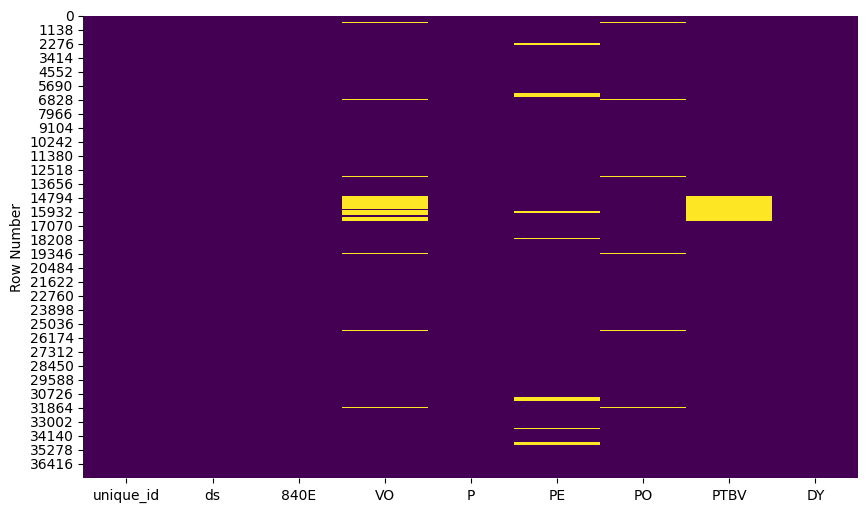

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
#plt.title("Missing Data Heatmap")
plt.ylabel("Row Number")
plt.show()

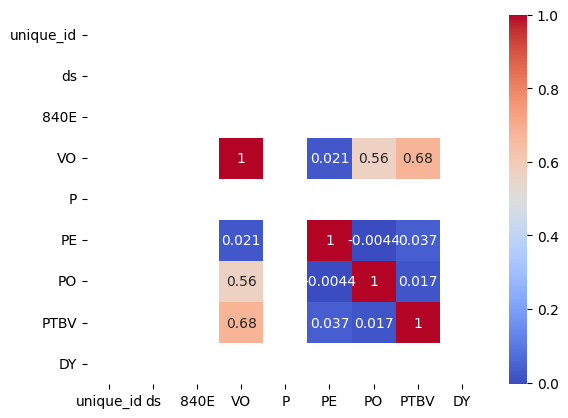

In [ ]:
missing_corr = df.isnull().corr()
sns.heatmap(missing_corr, annot=True, cmap="coolwarm")
#plt.title("Correlation of Missingness between Variables")
plt.show()

<ipython-input-31-4867ba4f5775>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('ds').apply(lambda x: x.isnull().sum()).plot(figsize=(10,6))


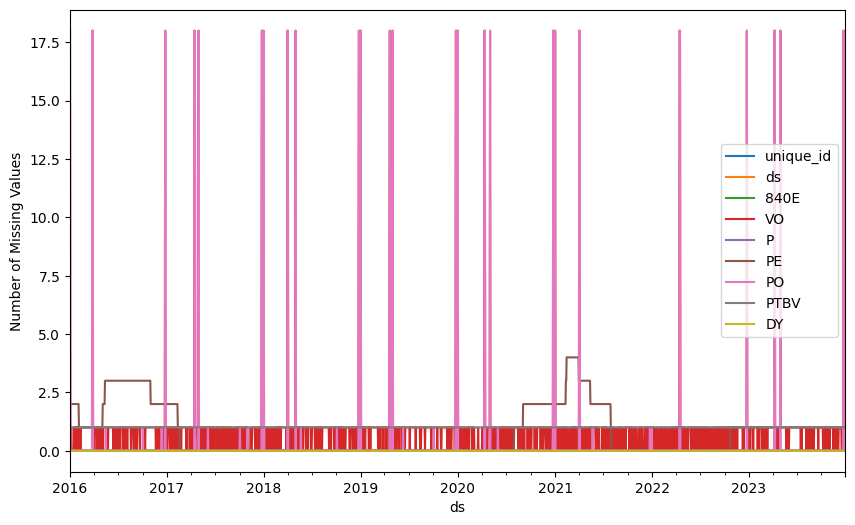

In [ ]:
# Example to check if missingness depends on time
df.groupby('ds').apply(lambda x: x.isnull().sum()).plot(figsize=(10,6))
#plt.title("Missing Data per Time (ds)")
plt.ylabel("Number of Missing Values")
plt.show()

## Missing data imputation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Convert 'ds' to datetime if it's not already
df['ds'] = pd.to_datetime(df['ds'])

# Split the data
train_df = df[df['ds'] < '2019-01-01']
val_df = df[(df['ds'] >= '2019-01-01') & (df['ds'] < '2020-01-01')]
test_df = df[df['ds'] >= '2020-01-01']

# Drop non-numeric columns (e.g., 'unique_id' and 'ds') from each split for imputation
train_numeric = train_df.drop(columns=['unique_id', 'ds'])
val_numeric = val_df.drop(columns=['unique_id', 'ds'])
test_numeric = test_df.drop(columns=['unique_id', 'ds'])

# Initialize the Iterative Imputer with your specified configuration
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=20,
    sample_posterior=True,
    skip_complete=True,
    random_state=42
).set_output(transform="pandas")

# Fit the imputer on the training data and transform all splits to avoid data leakage
train_imputed = imputer.fit_transform(train_numeric)
val_imputed = imputer.transform(val_numeric)
test_imputed = imputer.transform(test_numeric)

# Ensure only 'PE' and 'PTBV' can have negative values
for column in train_imputed.columns:
    if column not in ['PE', 'PTBV']:
        train_imputed[column] = train_imputed[column].clip(lower=0)
        val_imputed[column] = val_imputed[column].clip(lower=0)
        test_imputed[column] = test_imputed[column].clip(lower=0)

# Reattach 'unique_id' and 'ds' columns to each split
train_imputed['unique_id'] = train_df['unique_id'].values
train_imputed['ds'] = train_df['ds'].values
val_imputed['unique_id'] = val_df['unique_id'].values
val_imputed['ds'] = val_df['ds'].values
test_imputed['unique_id'] = test_df['unique_id'].values
test_imputed['ds'] = test_df['ds'].values

# Combine the splits back into a single DataFrame
combined_df = pd.concat([train_imputed, val_imputed, test_imputed]).sort_values(by=['unique_id', 'ds']).reset_index(drop=True)

# Display the resulting DataFrame
combined_df

,840E,VO,P,PE,PO,PTBV,DY,unique_id,ds
0,0.2049,0.000000,20.670,9.2,21.130379,1.08,0.00,ABN AMRO BANK,2016-01-01
1,0.2030,898.300000,20.670,9.2,20.600000,1.08,0.00,ABN AMRO BANK,2016-01-04
2,0.2025,827.700000,20.630,9.1,20.870000,1.08,0.00,ABN AMRO BANK,2016-01-05
3,0.1959,757.700000,20.130,8.9,20.650000,1.05,0.00,ABN AMRO BANK,2016-01-06
4,0.2068,1498.800000,19.695,8.7,19.965000,1.03,0.00,ABN AMRO BANK,2016-01-07
...,...,...,...,...,...,...,...,...,...
37543,0.1267,8742.962801,129.200,30.7,129.615123,17.77,1.47,WOLTERS KLUWER,2023-12-25
37544,0.1253,0.000000,129.200,30.7,129.384568,17.77,1.47,WOLTERS KLUWER,2023-12-26
37545,0.1285,415.600000,128.150,30.5,129.150000,17.62,1.48,WOLTERS KLUWER,2023-12-27
37546,0.1284,327.600000,128.050,30.5,128.450000,17.61,1.48,WOLTERS KLUWER,2023-12-28


In [ ]:
# List of columns to check for completeness (these will be the suffixes of your files)
columns_to_check = ['840E', 'P', 'PO', 'PE', 'DY', 'PTBV']

# Group by 'Company' and check for completeness of each column
complete_data_counts = {}

for col in columns_to_check:
    complete_data_counts[col] = combined_df.groupby('unique_id')[col].apply(lambda x: x.notna().all()).sum()

# Convert the dictionary to a DataFrame for display
complete_data_df = pd.DataFrame.from_dict(complete_data_counts, orient='index', columns=['Complete Data Count'])
complete_data_df

,Complete Data Count
840E,18
P,18
PO,18
PE,18
DY,18
PTBV,18


In [ ]:
missing_data = combined_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing_Count']
missing_data['Missing_Percent'] = (missing_data['Missing_Count'] / len(combined_df)) * 100
print(missing_data)

      Column  Missing_Count  Missing_Percent
0       840E              0              0.0
1         VO              0              0.0
2          P              0              0.0
3         PE              0              0.0
4         PO              0              0.0
5       PTBV              0              0.0
6         DY              0              0.0
7  unique_id              0              0.0
8         ds              0              0.0


In [ ]:
combined_df.to_csv('Data/AEX/ProAEX.csv', index=False)
combined_df

,840E,VO,P,PE,PO,PTBV,DY,unique_id,ds
0,0.2049,0.000000,20.670,9.2,21.130379,1.08,0.00,ABN AMRO BANK,2016-01-01
1,0.2030,898.300000,20.670,9.2,20.600000,1.08,0.00,ABN AMRO BANK,2016-01-04
2,0.2025,827.700000,20.630,9.1,20.870000,1.08,0.00,ABN AMRO BANK,2016-01-05
3,0.1959,757.700000,20.130,8.9,20.650000,1.05,0.00,ABN AMRO BANK,2016-01-06
4,0.2068,1498.800000,19.695,8.7,19.965000,1.03,0.00,ABN AMRO BANK,2016-01-07
...,...,...,...,...,...,...,...,...,...
37543,0.1267,8742.962801,129.200,30.7,129.615123,17.77,1.47,WOLTERS KLUWER,2023-12-25
37544,0.1253,0.000000,129.200,30.7,129.384568,17.77,1.47,WOLTERS KLUWER,2023-12-26
37545,0.1285,415.600000,128.150,30.5,129.150000,17.62,1.48,WOLTERS KLUWER,2023-12-27
37546,0.1284,327.600000,128.050,30.5,128.450000,17.61,1.48,WOLTERS KLUWER,2023-12-28


## Technical indicators

In [ ]:
df = pd.read_csv('Data/AEX/ProAEX.csv')
df['ds'] = pd.to_datetime(df['ds'])

# Split the dataset
train_df = df[(df['ds'] >= '2016-01-01') & (df['ds'] < '2020-01-01')]
val_df = df[(df['ds'] >= '2019-01-01') & (df['ds'] < '2020-01-01')]
test_df = df[df['ds'] >= '2020-01-01']

# Function to compute technical indicators for a given DataFrame
def compute_indicators(df_split):
    # Sort the DataFrame
    df_split = df_split.sort_values(['unique_id', 'ds']).reset_index(drop=True)

    # Compute Moving Averages (MA)
    # MA_s for s in [1,2,3]
    for s in [1,2,3]:
        df_split[f'MA_{s}'] = df_split.groupby('unique_id')['P'].transform(lambda x: x.rolling(window=s, min_periods=s).mean())
    # MA_l for l in [9,12]
    for l in [9,12]:
        df_split[f'MA_{l}'] = df_split.groupby('unique_id')['P'].transform(lambda x: x.rolling(window=l, min_periods=l).mean())

    # MA(s,l) signals
    ma_combinations = [(2,9), (3,9), (1,12), (2,12), (3,12)]
    for s,l in ma_combinations:
        df_split[f'MA({s},{l})'] = ((df_split[f'MA_{s}'] >= df_split[f'MA_{l}']).astype(int))

    # Compute Momentum (MOM)
    for k in [9,12]:
        df_split[f'P_shift_{k}'] = df_split.groupby('unique_id')['P'].shift(k)
        df_split[f'MOM({k})'] = (df_split['P'] >= df_split[f'P_shift_{k}']).astype(int)

    # Compute Relative Strength Index (RSI)
    df_split['ΔP'] = df_split.groupby('unique_id')['P'].diff()
    df_split['uct'] = df_split['ΔP'].apply(lambda x: x if x > 0 else 0)
    df_split['dct'] = df_split['ΔP'].apply(lambda x: -x if x < 0 else 0)

    for n in [7,14]:
        df_split[f'MA_uct_{n}'] = df_split.groupby('unique_id')['uct'].transform(lambda x: x.rolling(window=n, min_periods=n).mean())
        df_split[f'MA_dct_{n}'] = df_split.groupby('unique_id')['dct'].transform(lambda x: x.rolling(window=n, min_periods=n).mean())
        df_split[f'RSI_{n}'] = 100 - 100 / (1 + df_split[f'MA_uct_{n}'] / df_split[f'MA_dct_{n}'])
        df_split[f'RSI({n})'] = (df_split[f'RSI_{n}'] < 50).astype(int)

    # Compute Exponential Moving Averages (EMA)
    for s in [3,5]:
        df_split[f'EMA_{s}'] = df_split.groupby('unique_id')['P'].transform(lambda x: x.ewm(span=s, adjust=False, min_periods=s).mean())
    for l in [9,12]:
        df_split[f'EMA_{l}'] = df_split.groupby('unique_id')['P'].transform(lambda x: x.ewm(span=l, adjust=False, min_periods=l).mean())

    # EMA(s,l) signals
    ema_combinations = [(3,9), (5,9), (5,12)]
    for s,l in ema_combinations:
        df_split[f'EMA({s},{l})'] = (df_split[f'EMA_{s}'] >= df_split[f'EMA_{l}']).astype(int)

    # Select the required columns
    output_cols = ['unique_id', 'ds', '840E',
                   'MA(2,9)', 'MA(3,9)', 'MA(1,12)', 'MA(2,12)', 'MA(3,12)',
                   'MOM(9)', 'MOM(12)',
                   'RSI(7)', 'RSI(14)',
                   'EMA(3,9)', 'EMA(5,9)', 'EMA(5,12)', 'DY',	'PTBV',	'P',
                   'PO',	'VO',	'PE']
    # Ensure the columns exist in df_split
    existing_cols = [col for col in output_cols if col in df_split.columns]
    df_output = df_split[existing_cols]

    return df_output

# Compute indicators for each split
train_indicators = compute_indicators(train_df)
val_indicators = compute_indicators(val_df)
test_indicators = compute_indicators(test_df)

# Combine the splits back into a single DataFrame
df_combined = pd.concat([train_indicators, val_indicators, test_indicators], axis=0)
df_combined = df_combined.sort_values(['unique_id', 'ds']).reset_index(drop=True)

df_combined.to_csv('Data/AEX/3ProAEX.csv', index=False)
df_combined

,unique_id,ds,840E,"MA(2,9)","MA(3,9)","MA(1,12)","MA(2,12)","MA(3,12)",MOM(9),MOM(12),...,RSI(14),"EMA(3,9)","EMA(5,9)","EMA(5,12)",DY,PTBV,P,PO,VO,PE
0,ABN AMRO BANK,2016-01-01,0.2049,0,0,0,0,0,0,0,...,0,0,0,0,0.00,1.08,20.670,21.130379,0.000000,9.2
1,ABN AMRO BANK,2016-01-04,0.2030,0,0,0,0,0,0,0,...,0,0,0,0,0.00,1.08,20.670,20.600000,898.300000,9.2
2,ABN AMRO BANK,2016-01-05,0.2025,0,0,0,0,0,0,0,...,0,0,0,0,0.00,1.08,20.630,20.870000,827.700000,9.1
3,ABN AMRO BANK,2016-01-06,0.1959,0,0,0,0,0,0,0,...,0,0,0,0,0.00,1.05,20.130,20.650000,757.700000,8.9
4,ABN AMRO BANK,2016-01-07,0.2068,0,0,0,0,0,0,0,...,0,0,0,0,0.00,1.03,19.695,19.965000,1498.800000,8.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42241,WOLTERS KLUWER,2023-12-25,0.1267,0,0,0,0,0,0,0,...,1,0,0,0,1.47,17.77,129.200,129.615123,8742.962801,30.7
42242,WOLTERS KLUWER,2023-12-26,0.1253,0,0,0,0,0,0,0,...,1,0,0,0,1.47,17.77,129.200,129.384568,0.000000,30.7
42243,WOLTERS KLUWER,2023-12-27,0.1285,0,0,0,0,0,0,0,...,1,0,0,0,1.48,17.62,128.150,129.150000,415.600000,30.5
42244,WOLTERS KLUWER,2023-12-28,0.1284,0,0,0,0,0,0,0,...,1,0,0,0,1.48,17.61,128.050,128.450000,327.600000,30.5


## Stats

In [ ]:
df = pd.read_csv('Data/AEX/3ProAEX.csv')
df = df.drop(columns=['ds'])
with pd.option_context('display.float_format', '{:.6f}'.format):
    a = df.describe().T
a

,count,mean,std,min,25%,50%,75%,max
840E,42246.0,0.273419,0.140858,0.046300,0.1804,0.23840,0.328300,1.3554
"MA(2,9)",42246.0,0.549188,0.497581,0.000000,0.0000,1.00000,1.000000,1.0000
"MA(3,9)",42246.0,0.550064,0.497493,0.000000,0.0000,1.00000,1.000000,1.0000
"MA(1,12)",42246.0,0.553070,0.497181,0.000000,0.0000,1.00000,1.000000,1.0000
"MA(2,12)",42246.0,0.554893,0.496984,0.000000,0.0000,1.00000,1.000000,1.0000
"MA(3,12)",42246.0,0.554301,0.497049,0.000000,0.0000,1.00000,1.000000,1.0000
MOM(9),42246.0,0.557070,0.496738,0.000000,0.0000,1.00000,1.000000,1.0000
MOM(12),42246.0,0.557449,0.496694,0.000000,0.0000,1.00000,1.000000,1.0000
RSI(7),42246.0,0.441415,0.496562,0.000000,0.0000,0.00000,1.000000,1.0000
RSI(14),42246.0,0.422431,0.493952,0.000000,0.0000,0.00000,1.000000,1.0000


In [ ]:
# prompt: count the number of unique "unique_id" in df

# Assuming 'df' is the DataFrame named 'combined_df' from the previous code
unique_id_count = df['unique_id'].nunique()
print(f"Number of unique 'unique_id': {unique_id_count}")

Number of unique 'unique_id': 18


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import skew, kurtosis, jarque_bera, t, kstest
import ruptures as rpt

df = pd.read_csv('Data/AEX/3ProAEX.csv')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df = df[['unique_id', 'ds', '840E']]
df = df.rename(columns={'840E': 'y'})


# Define functions for each test
def adf_test(series):
    result = adfuller(series)
    return result[1] < 0.05  # True if p-value < 0.05 (passes the stationarity test)

def arch_test(series):
    result = het_arch(series)
    return result[1] < 0.05  # True if p-value < 0.05 (fails due to ARCH effects)

def change_point_detection(series):
    model = rpt.Pelt(model="rbf").fit(series.values.reshape(-1, 1))
    change_points = model.predict(pen=10)
    return len(change_points) > 1  # True if more than 1 change point is detected (fails)

def skew_kurt_test(series):
    skewness = skew(series)
    excess_kurt = kurtosis(series, fisher=True)
    return abs(skewness) > 0.5 or excess_kurt > 3  # True if skewness or excess kurtosis are significant (fails)

def jb_test(series):
    jb_stat, jb_pvalue = jarque_bera(series)
    return jb_pvalue < 0.05  # True if p-value < 0.05 (fails due to non-normality)



# Apply tests to each time series
results = df.groupby('unique_id')['y'].apply(lambda x: pd.Series({
    'adf_fail': adf_test(x),
    'arch_fail': arch_test(x),
    'change_point_fail': change_point_detection(x),
    'skew_kurt_fail': skew_kurt_test(x),
    'jb_fail': jb_test(x),
}))

# Summarize results
numTrues = results.unstack().melt()
numTrues[numTrues['value'] == True].groupby('variable')['value'].count()

,value
variable,
adf_fail,18
arch_fail,18
change_point_fail,18
jb_fail,18
skew_kurt_fail,18
